In [14]:
import sys

sys.path.append("../python")
sys.path.append("../pytorch-cnn-visualizations/src")

from facenet_pytorch import MTCNN, InceptionResnetV1
from hsemotion.facial_emotions import HSEmotionRecognizer
import math
import matplotlib.pyplot as plt
import numpy as np
import pickle
from PIL import Image
from sklearn import metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torchvision.transforms as transforms

from preprocess_data import EigenfacesDataset

In [2]:
def set_device(device_name="cpu"):
    if not device_name:
        if torch.cuda.is_available():
            device_name = "cuda"
        elif torch.backends.mps.is_available():
            device_name = "mps"
        else:
            device_name = "cpu"
    torch.device(device_name)
    return device_name

In [3]:
torch.manual_seed(315)
plt.rcParams['font.size'] = '16'

In [4]:
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
SCALE=1

In [17]:
def train(net, train_loader, test_loader,
          num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE,
          compute_accs=False, device="cpu"):
    """
    This function trains the given network on the training data for the given number of epochs.
    If compute_accs is true, evaluates the train and test accuracy of the network at the end of
    each epoch.

    Args:
        net: The neural network to train
        train_loader, test_loader: The pytorch dataset loaders for the trainst and testset
        num_epochs: The number of times to loop over the batches in train_loader
        learning_rate: The learning rate for the optimizer
        compute_accs: A bool flag for whether or not this function should compute the train and test
                      accuracies at the end of each epoch. This feature is useful for visualizing
                      how the model is learning, but slows down training time.
    Returns:
        The train and test accuracies if compute_accs is True, None otherwise
    """
    # First initialize the criterion (loss function) and the optimizer
    # (algorithm like gradient descent). Here we use a common loss function for multi-class
    # classification called the Cross Entropy Loss and the popular Adam algorithm.
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

    train_accs = []
    test_accs = []

    for epoch in range(1, num_epochs + 1):
        batch_num = 1
        for images, labels in train_loader:   # Loop over each batch in train_loader
            # If you are using a GPU, speed up computation by moving values to the GPU
            net = net.to(device)
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()               # Reset gradient for next computation
            outputs = net(images)               # Forward pass: compute the output class given a image
            loss = criterion(outputs, labels)   # Compute loss: difference between the pred and true 
            loss.backward()                     # Backward pass: compute the weight
            optimizer.step()                    # Optimizer: update the weights of hidden nodes
            
            if batch_num % BATCH_SIZE == 0:
                print(f'Epoch [{epoch}/{num_epochs}], Step [{batch_num}/{len(train_loader)}], '
                      f'Loss: {loss.item():.4f}')

            batch_num += 1

        if compute_accs:
            train_acc = accuracy(net, train_loader, device)
            test_acc = accuracy(net, test_loader, device)

            print(f'Epoch [{epoch}/{num_epochs}], ',
                  f'Train Accuracy {100 * train_acc:.2f}%, ',
                  f'Test Accuracy {100 * test_acc:.2f}%')
            
            train_accs.append(train_acc)
            test_accs.append(test_acc)

    if compute_accs:
        return train_accs, test_accs
    else:
        return None


def accuracy(net, data_loader, device):
    """
    For a given data_loader, evaluate the model on the dataset and compute its classification
    accuracy.

    Args:
        net: The neural network to train
        data_loader: A dataset loader for some dataset.
    Returns:
        The classificiation accuracy of the model on this dataset.
    """
    correct = 0
    total = 0
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = net(images)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores
        total += labels.size(0)                         # Increment the total count
        correct += (predicted == labels).sum().item()   # Increment the correct count

    return correct / total


def plot_history(histories):
    """
    Given a series of training/test accuracies from training, plots them to visualize learning.

    Args:
        histories: A list of dictionaries storing information about each model trained.
                   Each dictionary should have the keys:
                        * train_accs: A list of train accuracies
                        * test_accs: A list of test accuracies.
    """
    plt.figure(figsize=(16,10))
    epochs = list(range(1, len(histories[0]['train_accs']) + 1))
    for model_history in histories:
      label = model_history['label']
      val = plt.plot(epochs, model_history['test_accs'],
                     label=label + ' test')
      plt.plot(epochs, model_history['train_accs'], '--',
               color=val[0].get_color(), label=label + ' train')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim([1,max(epochs)])

In [18]:
class OneConvolutionNet(nn.Module):
    def __init__(self, num_classes, pretrained):
        super(OneConvolutionNet, self).__init__()
        self.pretrained = pretrained
        self.features = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=25,
                kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(
                kernel_size=2,
                stride=2),
            nn.Flatten(1, -1))
        self.classifier = nn.Sequential(
            nn.LazyLinear(out_features=num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [19]:
import torch
import torch.nn as nn

class Vgg_m_face_bn_fer_dag(nn.Module):

    def __init__(self, num_classes):
        super(Vgg_m_face_bn_fer_dag, self).__init__()
        self.meta = {'mean': [131.45376586914062, 103.98748016357422, 91.46234893798828],
                     'std': [1, 1, 1],
                     'imageSize': [224, 224, 3]}
        self.conv1 = nn.Conv2d(3, 96, kernel_size=[7, 7], stride=(2, 2))
        self.bn49 = nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=[5, 5], stride=(2, 2), padding=(1, 1))
        self.bn50 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=(0, 0), dilation=1, ceil_mode=True)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.bn51 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.bn52 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(512, 512, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
        self.bn53 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu5 = nn.ReLU()
        self.pool5 = nn.MaxPool2d(kernel_size=[3, 3], stride=[2, 2], padding=0, dilation=1, ceil_mode=False)
        self.fc6 = nn.Conv2d(512, 4096, kernel_size=[6, 6], stride=(1, 1))
        self.bn54 = nn.BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu6 = nn.ReLU()
        self.fc7 = nn.Conv2d(4096, 4096, kernel_size=[1, 1], stride=(1, 1))
        self.bn55 = nn.BatchNorm2d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu7 = nn.ReLU()
        self.classifier = nn.Linear(in_features=4096, out_features=num_classes, bias=True)

    def forward(self, data):
        data = data.repeat(1, 3, 1, 1)
        x1 = self.conv1(data)
        x2 = self.bn49(x1)
        x3 = self.relu1(x2)
        x4 = self.pool1(x3)
        x5 = self.conv2(x4)
        x6 = self.bn50(x5)
        x7 = self.relu2(x6)
        x8 = self.pool2(x7)
        x9 = self.conv3(x8)
        x10 = self.bn51(x9)
        x11 = self.relu3(x10)
        x12 = self.conv4(x11)
        x13 = self.bn52(x12)
        x14 = self.relu4(x13)
        x15 = self.conv5(x14)
        x16 = self.bn53(x15)
        x17 = self.relu5(x16)
        x18 = self.pool5(x17)
        x19 = self.fc6(x18)
        x20 = self.bn54(x19)
        x21 = self.relu6(x20)
        x22 = self.fc7(x21)
        x23 = self.bn55(x22)
        x24_preflatten = self.relu7(x23)
        x24 = x24_preflatten.view(x24_preflatten.size(0), -1)
        prediction = self.classifier(x24)
        return prediction

def vgg_m_face_bn_fer_dag(num_classes, pretrained, **kwargs):
    """
    load imported model instance

    Args:
        weights_path (str): If set, loads model weights from the given path
    """
    model = Vgg_m_face_bn_fer_dag(num_classes)
    if pretrained:
        state_dict = torch.load("../vgg_m_face_bn_fer_dag.pth")
        model.load_state_dict(state_dict, strict=False)
    return model

In [20]:
def get_loader(label, net_name, data_dir):
    all_transforms = [transforms.ToTensor()]
    if 'vgg' in net_name.lower():
        all_transforms.append(transforms.Resize((224, 224)))
    all_transforms.append(transforms.Normalize(0.5, 0.5))
    transform = transforms.Compose(all_transforms)
    dataset = EigenfacesDataset(
        data_dir=data_dir,
        label=label,
        scale=SCALE,
        transform=transform)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)
    return dataloader

def make_net(label, net_name, pretrained, freeze):
    train_loader = get_loader(label, net_name, '../train_data')
    test_loader = get_loader(label, net_name, '../test_data')
    num_classes = train_loader.dataset.num_classes
    device = set_device()
    if net_name == 'cnn_1':
        net = OneConvolutionNet(num_classes, pretrained)
    elif net_name == 'vgg_m':
        net = vgg_m_face_bn_fer_dag(num_classes, pretrained)
        if freeze:
            for param in net.parameters():
                param.requires_grad = False
            net.classifier.weight.requires_grad = True
            net.classifier.bias.requires_grad = True
    return (net, train_loader, test_loader, device)

def save_nets_and_histories(net_name, nets, histories):
    for clz, net in nets.items():
        torch.save(net.state_dict(), "{}_{}.pth".format(net_name, clz))
    with open('{}_history.pkl'.format(net_name), 'wb') as f:
        pickle.dump(histories, f)

def get_full_net_name(net_name, pretrained, freeze):
    if not pretrained:
        return '{}_untrained'.format(net_name)
    if not freeze:
        return '{}_finetuned'.format(net_name)
    return '{}_pretrained'.format(net_name)
        
def run_models(net_name, pretrained=False, freeze=False,
               labels=['eye_state', 'facial_expression', 'head_position']):
    nets = {}
    histories = []
    for label in labels:
        print(label)
        net, train_loader, test_loader, device = make_net(
            label, net_name, pretrained, freeze)
        train_history, test_history = train(
            net, train_loader, test_loader, 
            num_epochs=NUM_EPOCHS, 
            learning_rate=LEARNING_RATE, 
            compute_accs=True,
            device=device)
        histories.append({
            'label': label,
            'train_accs': train_history,
            'test_accs': test_history
        })
        nets[label] = net.eval()
        
    full_net_name = get_full_net_name(net_name, pretrained, freeze)
    save_nets_and_histories(full_net_name, nets, histories)

    plot_history(histories)
    return (nets, histories)

eye_state
Epoch [1/20],  Train Accuracy 57.76%,  Test Accuracy 48.39%
Epoch [2/20],  Train Accuracy 74.89%,  Test Accuracy 62.37%
Epoch [3/20],  Train Accuracy 84.47%,  Test Accuracy 67.20%
Epoch [4/20],  Train Accuracy 65.07%,  Test Accuracy 50.00%
Epoch [5/20],  Train Accuracy 79.68%,  Test Accuracy 55.38%
Epoch [6/20],  Train Accuracy 56.85%,  Test Accuracy 52.15%
Epoch [7/20],  Train Accuracy 87.21%,  Test Accuracy 60.22%
Epoch [8/20],  Train Accuracy 94.52%,  Test Accuracy 75.81%
Epoch [9/20],  Train Accuracy 98.63%,  Test Accuracy 76.34%
Epoch [10/20],  Train Accuracy 99.09%,  Test Accuracy 84.95%
Epoch [11/20],  Train Accuracy 99.77%,  Test Accuracy 85.48%
Epoch [12/20],  Train Accuracy 99.77%,  Test Accuracy 83.33%
Epoch [13/20],  Train Accuracy 100.00%,  Test Accuracy 81.72%
Epoch [14/20],  Train Accuracy 100.00%,  Test Accuracy 81.72%
Epoch [15/20],  Train Accuracy 100.00%,  Test Accuracy 82.26%
Epoch [16/20],  Train Accuracy 100.00%,  Test Accuracy 81.72%
Epoch [17/20],  Tra

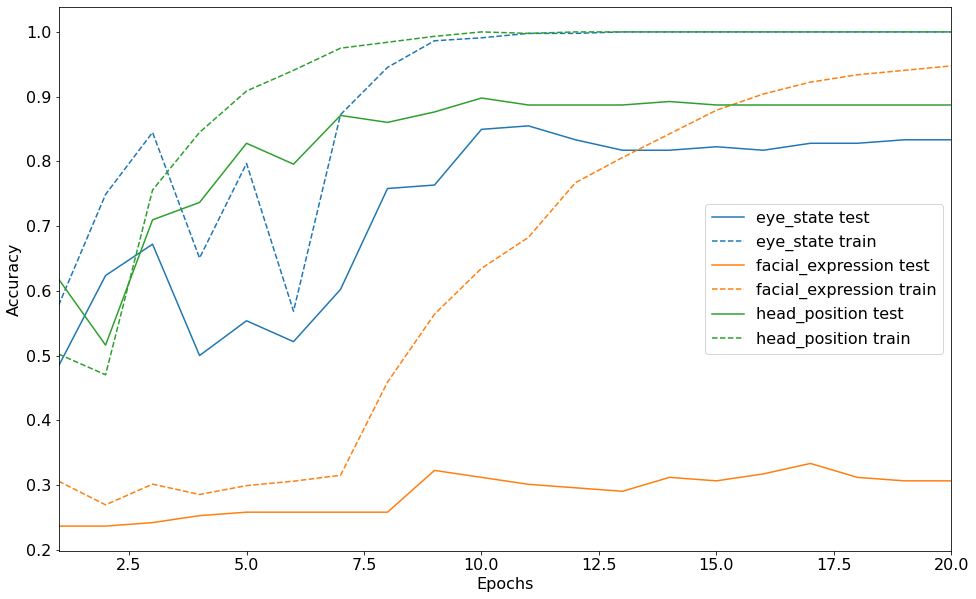

In [21]:
(one_conv_nets, one_conv_nets_history) = run_models(
    'cnn_1', pretrained=False, freeze=False)

eye_state
Epoch [1/20],  Train Accuracy 91.55%,  Test Accuracy 89.78%
Epoch [2/20],  Train Accuracy 96.80%,  Test Accuracy 95.16%
Epoch [3/20],  Train Accuracy 97.03%,  Test Accuracy 95.70%
Epoch [4/20],  Train Accuracy 99.09%,  Test Accuracy 96.24%
Epoch [5/20],  Train Accuracy 99.77%,  Test Accuracy 96.24%
Epoch [6/20],  Train Accuracy 99.77%,  Test Accuracy 96.77%
Epoch [7/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [8/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [9/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [10/20],  Train Accuracy 100.00%,  Test Accuracy 95.70%
Epoch [11/20],  Train Accuracy 100.00%,  Test Accuracy 95.70%
Epoch [12/20],  Train Accuracy 100.00%,  Test Accuracy 95.70%
Epoch [13/20],  Train Accuracy 100.00%,  Test Accuracy 95.70%
Epoch [14/20],  Train Accuracy 100.00%,  Test Accuracy 96.24%
Epoch [15/20],  Train Accuracy 100.00%,  Test Accuracy 96.24%
Epoch [16/20],  Train Accuracy 100.00%,  Test Accuracy 96.24%
Epoch [17/20]

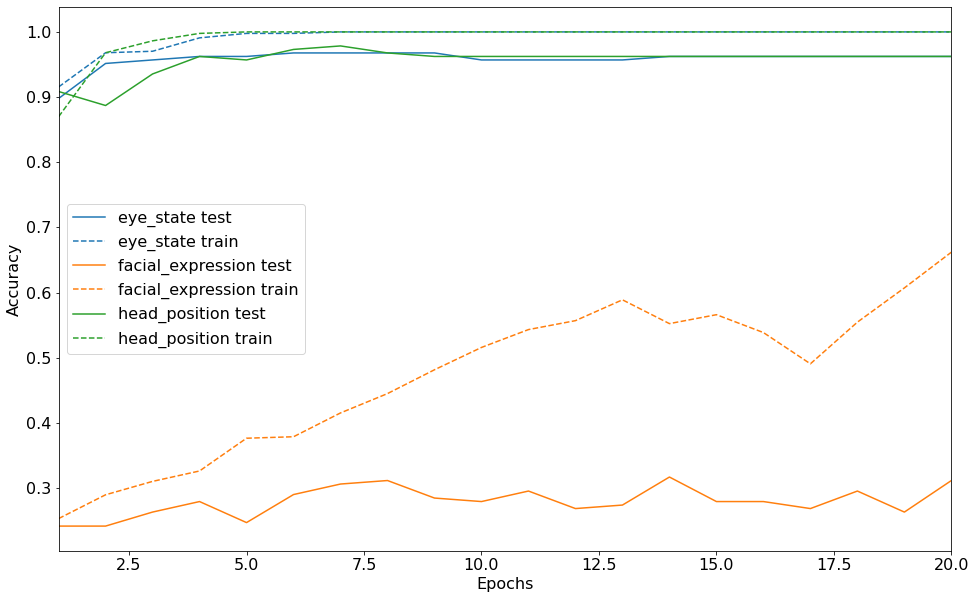

In [23]:
(vgg_m_untrained, vgg_m_untrained_history) = run_models(
    'vgg_m', pretrained=False, freeze=False)

eye_state
Epoch [1/20],  Train Accuracy 98.40%,  Test Accuracy 97.31%
Epoch [2/20],  Train Accuracy 99.54%,  Test Accuracy 97.85%
Epoch [3/20],  Train Accuracy 99.77%,  Test Accuracy 98.92%
Epoch [4/20],  Train Accuracy 99.54%,  Test Accuracy 97.85%
Epoch [5/20],  Train Accuracy 100.00%,  Test Accuracy 97.85%
Epoch [6/20],  Train Accuracy 100.00%,  Test Accuracy 97.85%
Epoch [7/20],  Train Accuracy 100.00%,  Test Accuracy 97.31%
Epoch [8/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [9/20],  Train Accuracy 100.00%,  Test Accuracy 97.31%
Epoch [10/20],  Train Accuracy 100.00%,  Test Accuracy 97.31%
Epoch [11/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [12/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [13/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [14/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [15/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [16/20],  Train Accuracy 100.00%,  Test Accuracy 96.77%
Epoch [17/2

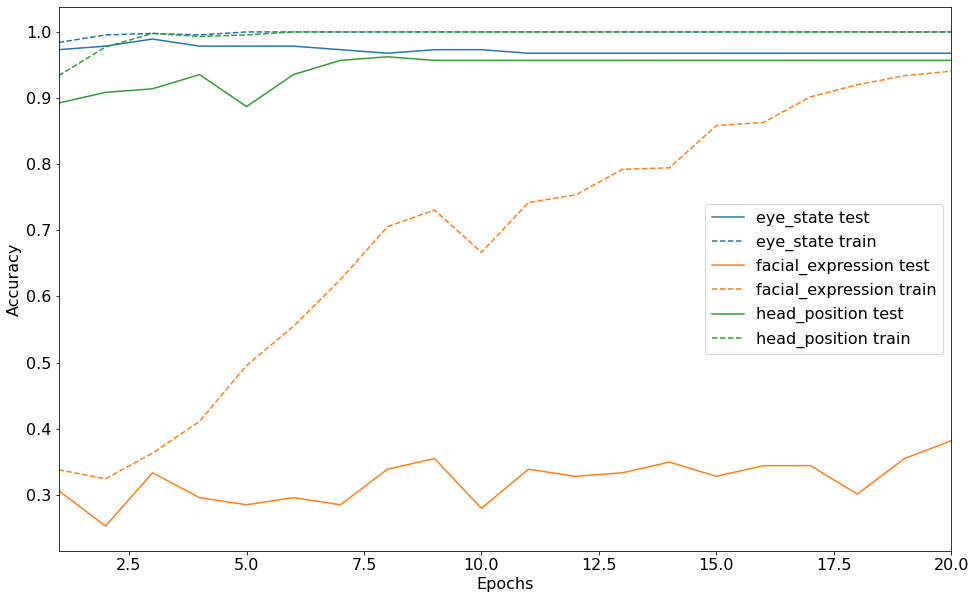

In [24]:
(vgg_m_finetuned, vgg_m_finetuned_history) = run_models(
    'vgg_m', pretrained=True, freeze=False)

eye_state
Epoch [1/20],  Train Accuracy 95.43%,  Test Accuracy 87.10%
Epoch [2/20],  Train Accuracy 97.95%,  Test Accuracy 89.78%
Epoch [3/20],  Train Accuracy 98.40%,  Test Accuracy 90.86%
Epoch [4/20],  Train Accuracy 99.77%,  Test Accuracy 92.47%
Epoch [5/20],  Train Accuracy 99.77%,  Test Accuracy 93.55%
Epoch [6/20],  Train Accuracy 99.77%,  Test Accuracy 94.09%
Epoch [7/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [8/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [9/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [10/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [11/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [12/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [13/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [14/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [15/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [16/20],  Train Accuracy 100.00%,  Test Accuracy 94.09%
Epoch [17/20]

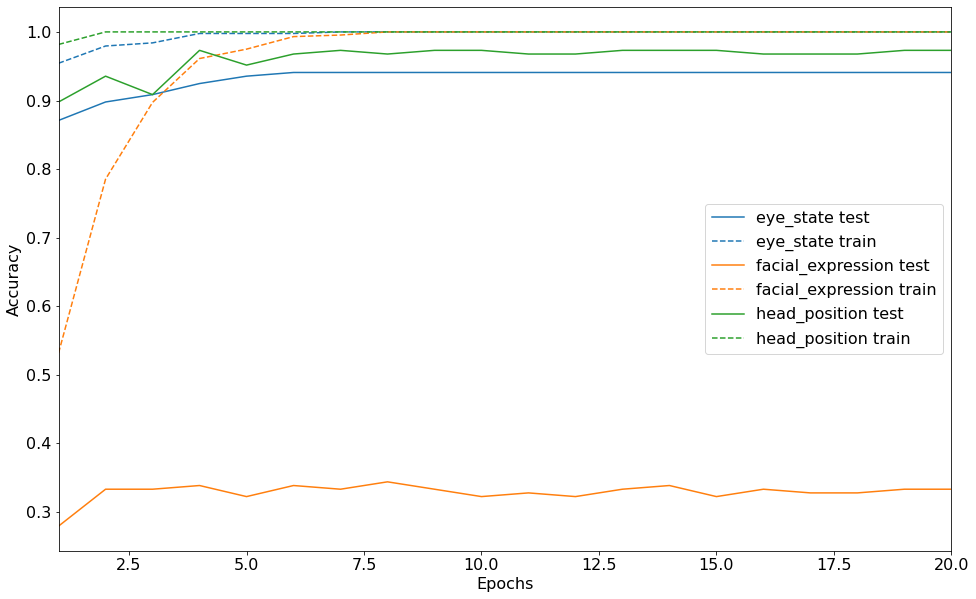

In [25]:
(vgg_m_pretrained, vgg_m_pretrained_history) = run_models(
    'vgg_m', pretrained=True, freeze=True)

In [26]:
pretty_net = {
    'cnn1': 'CNN-1',
    'vgg_m_untrained': 'Untrained VGG-M',
    'vgg_m_finetuned': 'Fine-tuned VGG-M',
    'vgg_m_pretrained': 'Pretrained VGG-M'}

label_classes = [
    ('eye_state', [0,1]),
    ('head_position', [0,1,2,3]),
    ('facial_expression', [0,1,2,3])]

pretty_label = {
    'eye_state': 'Eye state',
    'head_position': 'Head position',
    'facial_expression': 'Facial expression'
}

label_base_accuracy = [
    ('eye_state', 0.5),
    ('head_position', 0.25),
    ('facial_expression', 0.25)]

In [29]:
net_names = [
    (one_conv_nets, 'cnn1'),
    (vgg_m_untrained, 'vgg_m_untrained'),
    (vgg_m_finetuned, 'vgg_m_finetuned'),
    (vgg_m_pretrained, 'vgg_m_pretrained')]

histories = [
    ('CNN-1', one_conv_nets_history),
    ('Untrained VGG-M', vgg_m_untrained_history),
    ('Fine-tuned VGG-M', vgg_m_finetuned_history),
    ('Pretrained VGG-M', vgg_m_pretrained_history)]

In [31]:
def confusion_matrix(nets, model_name, label, max_num):
    net = nets[label].eval()
    data_loader = get_loader(label, model_name, '../test_data')
    
    y_true = []
    y_pred = []
    
    for images, labels in data_loader:
        outputs = net(imag es)                           # Make predictions
        _, predicted = torch.max(outputs.data, 1)       # Choose class with highest scores

        y_true.extend(labels.detach().cpu().numpy().tolist())
        y_pred.extend(predicted.detach().cpu().numpy().tolist())

    matrix = metrics.confusion_matrix(y_true, y_pred)
    disp = metrics.ConfusionMatrixDisplay(matrix, display_labels=data_loader.dataset.classes)
    matrix_plot = disp.plot(cmap='inferno', colorbar=False)
    matrix_plot.im_.set_clim(vmin=0,vmax=max_num)
    plt.setp(matrix_plot.ax_.get_yticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    plt.setp(matrix_plot.ax_.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
    matrix_plot.figure_.savefig(
        "../results/{}_{}_confusion".format(
            model_name, label), bbox_inches='tight')

/Users/apple/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/Users/apple/anaconda3/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to b

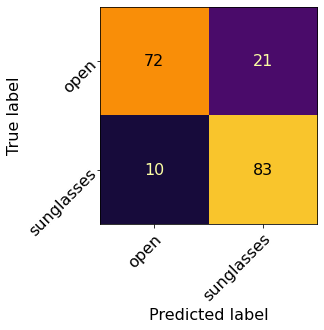

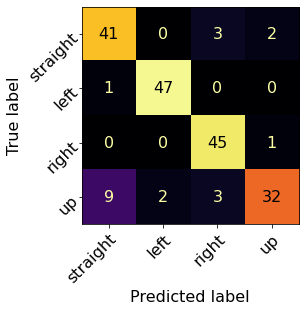

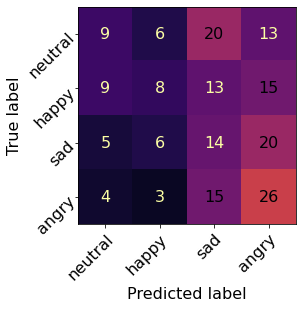

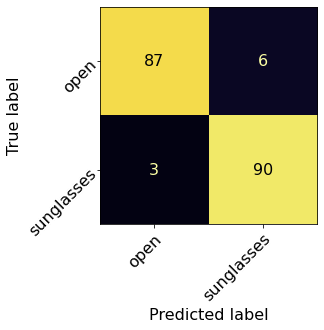

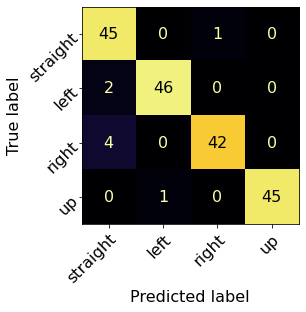

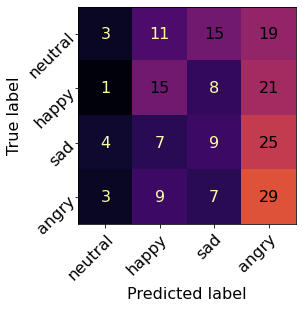

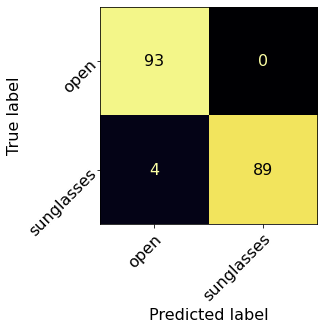

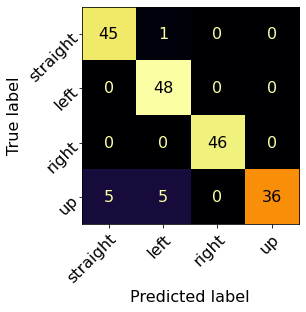

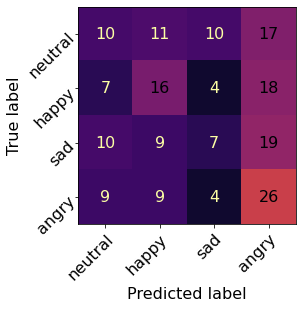

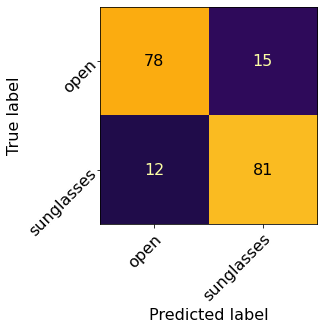

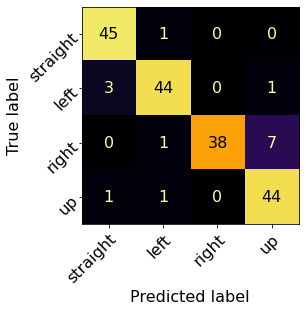

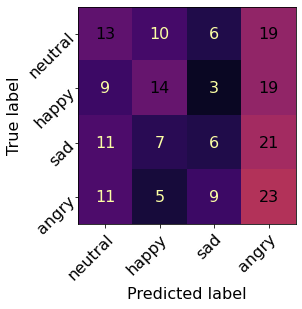

In [33]:
for nets, model_name in net_names:
    for label, target_classes in label_classes:
        max_num = 6*(32/len(target_classes))
        confusion_matrix(nets, model_name, label, max_num)

In [34]:
from importlib import reload
import generate_regularized_class_specific_samples
reload(generate_regularized_class_specific_samples)
from generate_regularized_class_specific_samples import RegularizedClassSpecificImageGeneration

for nets, model_name in net_names:
    for label, target_classes in label_classes:
        print(model_name, label)
        for target_class in target_classes:
            train_loader = get_loader(label, model_name, '../train_data')
            if 'vgg' in model_name.lower():
                img_size = (224, 224)
            else:
                img_size = (train_loader.dataset.width, train_loader.dataset.height)
            csig = RegularizedClassSpecificImageGeneration(
                nets[label], target_class=target_class, num_channels=1,
                img_size=img_size, label=label, model_name=model_name)
            csig.generate()

cnn1 eye_state
Iteration: 16 Loss -20.19
Iteration: 33 Loss -38.01
Iteration: 50 Loss -50.69
Iteration: 66 Loss -53.50
Iteration: 83 Loss -62.33


/Users/apple/Library/CloudStorage/OneDrive-Stanford/eigenfaces/ipynb/../pytorch-cnn-visualizations/src/generate_regularized_class_specific_samples.py:105: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(


Iteration: 100 Loss -41.18
Iteration: 116 Loss -41.77
Iteration: 133 Loss -49.83
Iteration: 16 Loss -32.48
Iteration: 33 Loss -57.93
Iteration: 50 Loss -75.45
Iteration: 66 Loss -79.16
Iteration: 83 Loss -91.18
Iteration: 100 Loss -63.03
Iteration: 116 Loss -63.96
Iteration: 133 Loss -75.08
cnn1 head_position
Iteration: 16 Loss -19.34
Iteration: 33 Loss -35.04
Iteration: 50 Loss -46.54
Iteration: 66 Loss -48.10
Iteration: 83 Loss -57.02
Iteration: 100 Loss -32.48
Iteration: 116 Loss -32.85
Iteration: 133 Loss -41.23
Iteration: 16 Loss -26.15
Iteration: 33 Loss -46.12
Iteration: 50 Loss -59.79
Iteration: 66 Loss -62.69
Iteration: 83 Loss -71.18
Iteration: 100 Loss -50.54
Iteration: 116 Loss -51.00
Iteration: 133 Loss -58.71
Iteration: 16 Loss -30.55
Iteration: 33 Loss -51.08
Iteration: 50 Loss -66.27
Iteration: 66 Loss -69.35
Iteration: 83 Loss -79.54
Iteration: 100 Loss -55.56
Iteration: 116 Loss -56.11
Iteration: 133 Loss -64.86
Iteration: 16 Loss -14.22
Iteration: 33 Loss -24.44
Iter

Iteration: 83 Loss -84.14
Iteration: 100 Loss -120.72
Iteration: 116 Loss -123.40
Iteration: 133 Loss -85.85
Iteration: 16 Loss -14.17
Iteration: 33 Loss -29.76
Iteration: 50 Loss -46.52
Iteration: 66 Loss -58.38
Iteration: 83 Loss -61.75
Iteration: 100 Loss -76.61
Iteration: 116 Loss -71.96
Iteration: 133 Loss -67.80
Iteration: 16 Loss -21.62
Iteration: 33 Loss -39.39
Iteration: 50 Loss -58.83
Iteration: 66 Loss -63.44
Iteration: 83 Loss -79.55
Iteration: 100 Loss -93.26
Iteration: 116 Loss -100.54
Iteration: 133 Loss -80.98


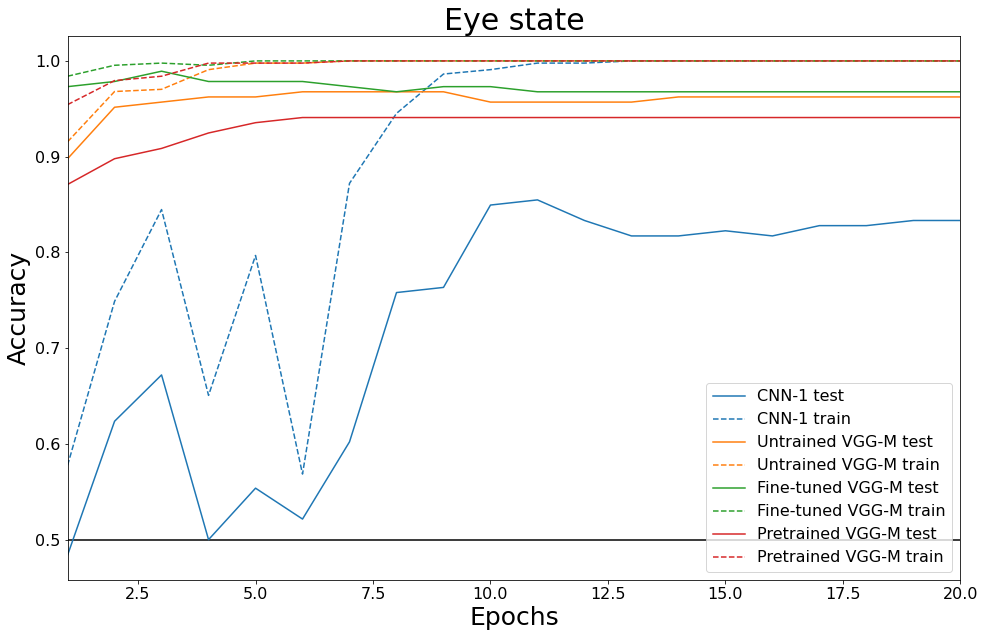

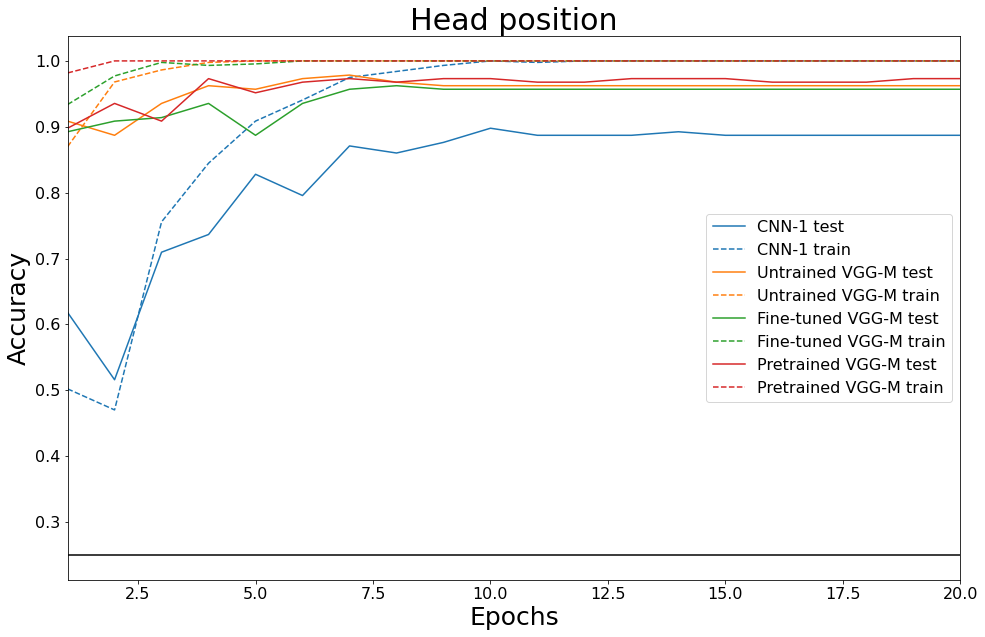

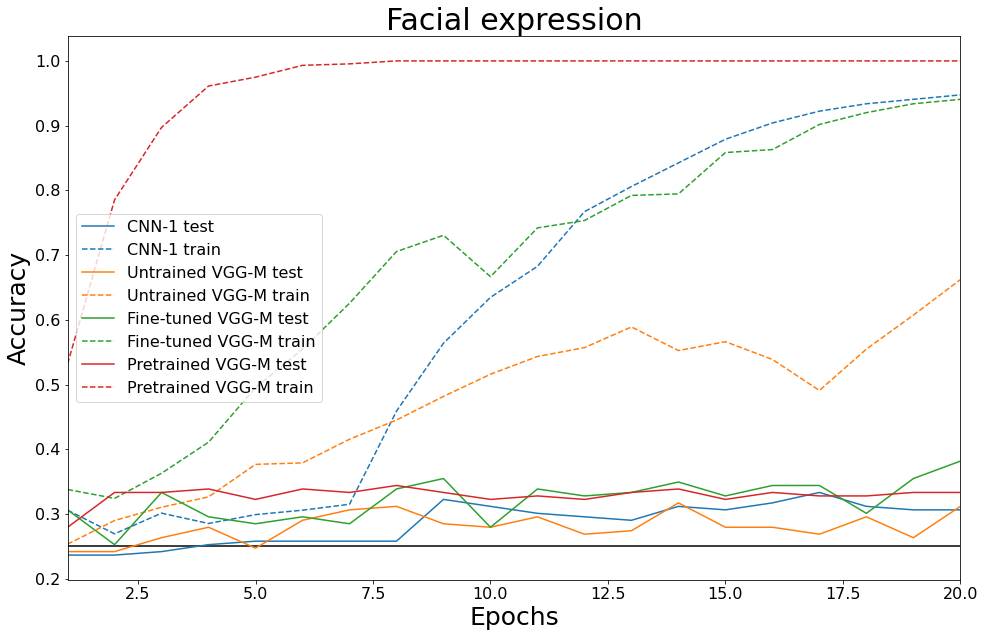

In [35]:
for (label, base_accuracy) in label_base_accuracy:
    plt.figure(figsize=(16,10))
    plt.axhline(base_accuracy, color='black')
    for (name, history) in histories:
        model_history = [h for h in history if h['label'] == label][0]
        epochs = list(range(1, len(model_history['train_accs']) + 1))
        val = plt.plot(epochs, model_history['test_accs'],
                       label=name + ' test')
        plt.plot(epochs, model_history['train_accs'], '--',
                 color=val[0].get_color(), label=name + ' train')

    plt.xlabel('Epochs', fontsize=25)
    plt.ylabel('Accuracy', fontsize=25)
    plt.legend()
    plt.xlim([1,max(epochs)])
    plt.title(pretty_label.get(label), fontsize=30)